# Exercise 1

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.


First, set $Y_t = \sigma W_t - \frac{1}{2} \sigma^2t$.
We have that $dY_t = \sigma dW_t - \frac{1}{2} \sigma^2 dt$. Using Itô's formula with $f(x) = s_0e^x$, we obtain: 
\begin{equation}
\begin{split}
dS_t &= df(X_t) \\
&= \left(\frac{1}{2}\sigma^2 S_t - \frac{1}{2}\sigma^2 S_t\right)dt + \sigma S_t dW_t \\
&= \sigma S_t dW_t
\end{split}
\end{equation}
Which is exactly the Black-Scholes equation with null risk-free rate.


### Question 1.b - Generate dataset

In [1]:
import torch
import time

# Parameters
N = 30
T = 30 / 365
s0 = 1
sigma = 0.5

# Generate the training set
Train = torch.stack([torch.cat((torch.tensor([s0]),
                                torch.exp(torch.cumsum(- (sigma**2 * T) / (2 * N)
                                + sigma * torch.sqrt(torch.tensor(T / N)) 
                                * torch.randn(N), dim=0)))) for _ in range(10**5)])

# Generate the test set
Test = torch.stack([torch.cat((torch.tensor([s0]),
                               torch.exp(torch.cumsum(- (sigma**2 * T) / (2 * N)
                                + sigma * torch.sqrt(torch.tensor(T / N)) 
                                * torch.randn(N), dim=0)))) for _ in range(10**4)])

### Question 1.c - Model implementation

In [ ]:
# Implement the deep hedging model

nh1 = 64
nh2 = 64
nh3 = 32

networks = [torch.nn.Sequential(
    torch.nn.Linear(1, nh1),
    torch.nn.ReLU(),
    torch.nn.Linear(nh1, nh2),
    torch.nn.ReLU(),
    torch.nn.Linear(nh2, nh3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(nh3, 1)
) for _ in range(N)]

### Question 1.d - Model training

100%|██████████| 100/100 [08:10<00:00,  4.91s/it, loss=8.09e-5]


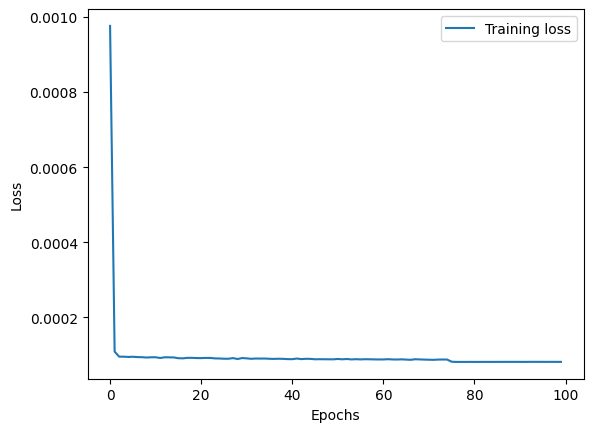

In [3]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import matplotlib.pyplot as plt
# Implement the payoff function of a call option
K = 1
g = lambda x: torch.relu(x-K)

# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity
def C(x: torch.Tensor, t: float):
    d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(x / K)) + (sigma ** 2 / 2) * (T - t))
    d_minus = d_plus - sigma * torch.sqrt(torch.tensor(T - t))
    return torch.special.ndtr(d_plus) * x - torch.special.ndtr(d_minus) * K

# Train the model
p = C(1,0)
n_epochs = 100
lr = 1e-2
batch_size = 1000
milestones = [75]

# Instantiate an optimizer (i.e. a (Stochastic) Gradient Descent algorithm)
optimizer = torch.optim.Adam([param for network in networks for param in network.parameters()], lr=lr)

# Instantiate a scheduler to decrease the learning rate during training according to a pre-defined rule
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

train_loader = DataLoader(TensorDataset(Train), batch_size=batch_size, shuffle=True)

M1_TST = time.time()
losses = []
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    epoch_loss = 0
    for batch in train_loader:
        batch = batch[0]
        s_T = batch[:, -1]
        H = torch.zeros(batch.size(0),N) 
        optimizer.zero_grad()
        H = torch.stack([networks[i](torch.log(batch[:, i]).unsqueeze(1)).squeeze() for i in range(N)], dim=1)     
        S = batch[:, 1:] - batch[:, :-1]  
        batch_loss = ((g(s_T) - p - torch.sum(H * S, dim=1)) ** 2).mean()
        
        batch_loss.backward()
        optimizer.step()
        

        epoch_loss += batch_loss.item()

    # Average loss per batch
    epoch_loss /= len(train_loader)
    training_loop.set_postfix(loss=epoch_loss)
    
    # Step the scheduler
    scheduler.step()

    # Save training loss for plotting
    losses.append(epoch_loss)
M1_TET = time.time()
# Plot the training loss
plt.plot(losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Question 1.e - Model evaluation

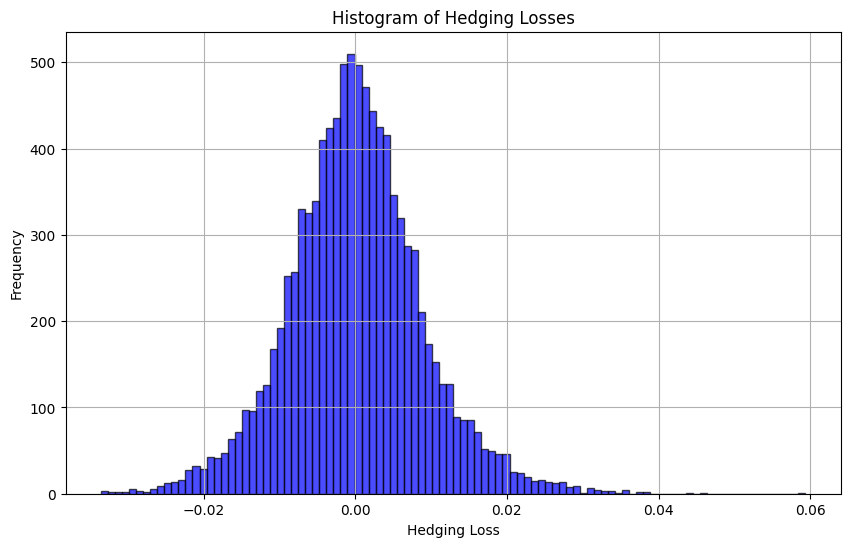

Mean of hedging losses: 0.0001
Standard deviation of hedging losses: 0.0089


In [4]:
# Evaluate the hedging losses on the test set
S_T = Test[:,-1]
H_test = torch.zeros(Test.size(0),N)
for i in range(N):
    input_data = torch.log(Test[:, i]).unsqueeze(1)  
    H_test[:, i] = networks[i](input_data).squeeze()    
S_test = Test[:, 1:] - Test[:, :-1] 
loss = (g(S_T) - p - torch.sum(H_test * S_test, dim=1)).detach()

# Plot a histogram of the hedging losses and print mean and standard deviation

plt.figure(figsize=(10, 6))
plt.hist(loss.numpy(), bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print mean and standard deviation of the losses
mean_loss = torch.mean(loss).item()
std_loss = torch.std(loss).item()
print(f"Mean of hedging losses: {mean_loss:.4f}")
print(f"Standard deviation of hedging losses: {std_loss:.4f}")

A few questions for you to consider...

Have you trained your model well?
- Are the losses centered on zero?
- Is their standard deviation sufficiently small?

How can you improve performance?
- train for more epochs
- try different batch sizes
- try a different learning rate
- use a learning rate scheduler (see https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- try a different activation function
- change the networks' architectures (more/less hidden neurons, more/less hidden layers)
- reduce/increase the learning rate
- implement regularization (use the `weight_decay` argument in the optimizer)
- implement batch-normalization (see https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- experiment with different optimizers
- ask in the forum

# Exercise 2

### Question 2.a - Compute analytical solution

Show a **step-by-step** derivation of the analytical hedging strategy:

\begin{align*}
H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s} \\
& = \frac{\partial }{\partial s} \left( \Phi(d_+) s - \Phi(d_+ - \sigma \sqrt{T-t})Ke^{-r(T-t)} \right) \\
&= (\frac{\partial}{\partial s} d_+) \Phi '(d_+)s + \Phi(d_+) - (\frac{\partial}{\partial s} d_+) \Phi'(d_+ - \sigma \sqrt{T-t})Ke^{-r(T-t)}
\end{align*}

Now, as 
\begin{align*}
\frac{\partial}{\partial s}d_+ &= \frac{\partial}{\partial s} \frac{1}{\sigma \sqrt{T-t}} \left( \log(s/K) + (r + \sigma^2/2)(T-t)\right) \\
&= \frac{1}{s\sigma\sqrt{T-t}}
\end{align*}
We obtain
\begin{align*}
\frac{\partial C(s,t)}{\partial s} &= \frac{1}{s\sigma \sqrt{T-t}} \Phi'(d_+)s + \Phi(d_+) - \frac{1}{s\sigma\sqrt{T-t}} \Phi'(d_-)Ke^{-r(T-t)}\\
&= \frac{1}{s\sigma\sqrt{T-t}} \left(\Phi'(d_+)s - \Phi'(d_-)Ke^{-r(T-t)} \right) + \Phi(d_+)
\end{align*}

Lastly, notice that
\begin{align*}
Ke^{-r(T-t)} \Phi'(d_-) &= Ke^{-r(T-t)} \frac{1}{\sqrt{2\pi}} e^{-(d_+ - \sigma \sqrt{T-t})^2 /2} \\
&= Ke^{-r(T-t)} e^{d_+ \sigma \sqrt{T-t}} e^{-\sigma^2 \frac{T-t}{2}} \Phi'(d_+) \\
&=Ke^{-(r + \sigma^2/2)(T-t)} \frac{s}{K} e^{(r+\sigma^2/2)(T-t)} \Phi'(d_+) \\
&= s\Phi'(d_+)
\end{align*}

Thus 

$$H^{\text{BS}}_t(s) = \Phi(d_+)$$

### Question 2.b - Analytical solution evaluation

/var/folders/mt/f_38sfcx1y30rt3qpp9_vw6h0000gn/T/ipykernel_27359/3665163386.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))


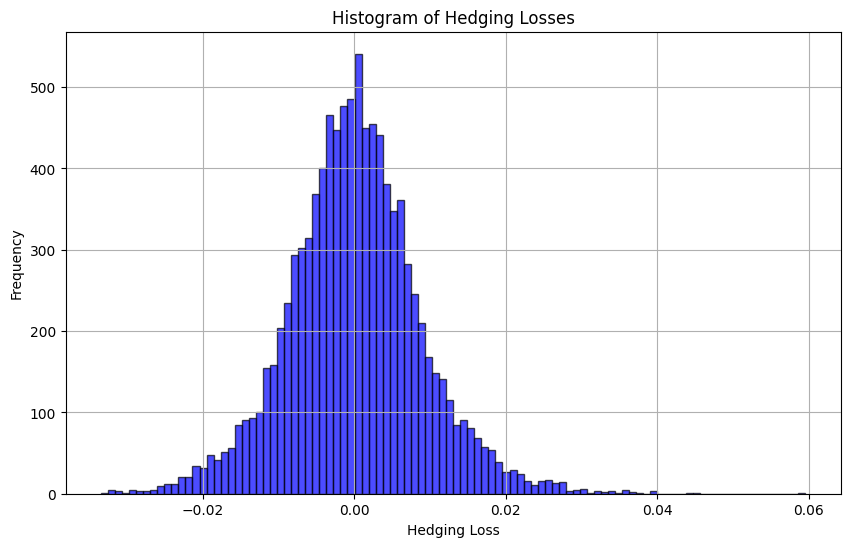

Mean of hedging losses: 0.0001
Standard deviation of hedging losses: 0.0088


In [5]:
from torch.distributions import Normal

def dsC(s: torch.Tensor, t: float):
    d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))
    return torch.special.ndtr(d_plus)



# Evaluate the losses of the analytical hedging strategies on the test set
times = T*torch.arange(0,N)/N
s = Test[:, :-1]
H_analytical = torch.stack([dsC(s[i], times) for i in range(s.size(0))])
analytical_loss = (g(S_T) - p - torch.sum(H_analytical * S_test, dim=1)).detach()

plt.figure(figsize=(10, 6))
plt.hist(analytical_loss, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print mean and standard deviation of the losses
amean_loss = torch.mean(analytical_loss).item()
astd_loss = torch.std(analytical_loss).item()
print(f"Mean of hedging losses: {amean_loss:.4f}")
print(f"Standard deviation of hedging losses: {astd_loss:.4f}")
    


**Something to think about**: in the Black-Scholes model every option can be perfectly hedged using its analytical hedging strategy.
But the analytical solution you have computed does not give zero losses. Can you explain why?

### Question 2.c - Hedging losses comparison

How does your deep hedging model compare with the analytical solution?
- After adding 2 hidden layers, our deep hedging model works as good as the analytical solution.


### Question 2.d - Learned strategy comparison

/var/folders/mt/f_38sfcx1y30rt3qpp9_vw6h0000gn/T/ipykernel_27359/1165237153.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.plot(s_plot.numpy(),networks[j](torch.log(torch.tensor(s_plot)).unsqueeze(1)).squeeze().detach().numpy(), label=f'$H_{{t_{j}}}$ (NN)', linestyle='--')
/var/folders/mt/f_38sfcx1y30rt3qpp9_vw6h0000gn/T/ipykernel_27359/3665163386.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d_plus = (1 / (sigma * torch.sqrt(torch.tensor(T - t)))) * (torch.log(torch.tensor(s / K)) + (sigma ** 2 / 2) * (T - t))


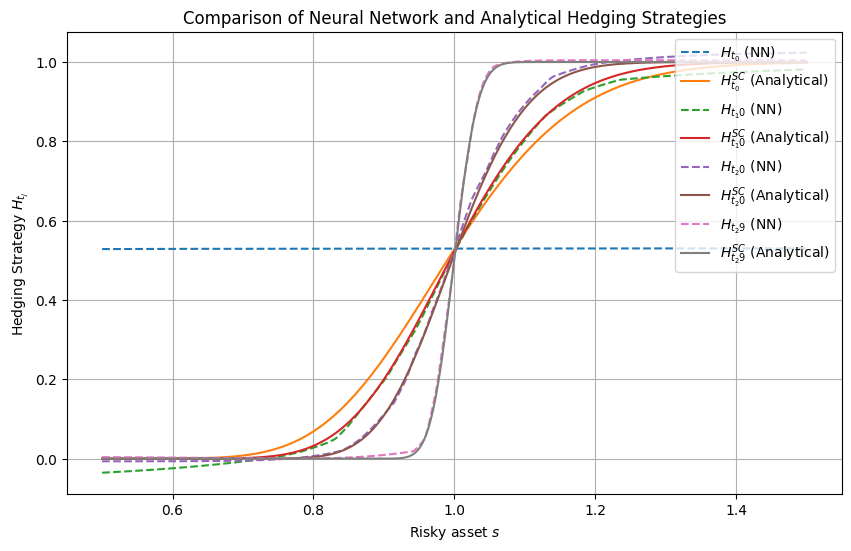

In [6]:
# Ensure s_plot_net and s_plot are defined as per the previous context
s_plot = torch.linspace(0.5, 1.5, 1000)  # Create a range of input prices
s_plot_net = s_plot.view(-1, 1).repeat(1, 30)  # Repeat to match input format for the network

# Time indices for comparison
index = torch.tensor([0, 10, 20, 29])  # Selected time points for plotting

# Create a plot for comparison
plt.figure(figsize=(10, 6))

# Loop over the selected time indices
for j in index:
    # Plot the network's hedging strategy at time t_j
    
    plt.plot(s_plot.numpy(),networks[j](torch.log(torch.tensor(s_plot)).unsqueeze(1)).squeeze().detach().numpy(), label=f'$H_{{t_{j}}}$ (NN)', linestyle='--')

    # Plot the analytical solution at the same time t_j
    plt.plot(s_plot.numpy(), dsC(s_plot, T * j / N).detach().numpy(), label=f'$H^{{SC}}_{{t_{j}}}$ (Analytical)')

# Add plot labels and title
plt.xlabel('Risky asset $s$')
plt.ylabel('Hedging Strategy $H_{t_j}$')
plt.title('Comparison of Neural Network and Analytical Hedging Strategies')
plt.legend(loc='upper right')
plt.grid(True)

# Show the plot
plt.show()

- For what times $t_j$ are the two functions most similar? They are the most similar for $t_j \neq 0$
- Why? Because for $t_0$, the model's only training data is $s_0$, therefore it cannot improve.

# Exercise 3

### Question 3.a - Model implementation

In [7]:
# Implement the new deep hedging model
complete_network = torch.nn.Sequential(torch.nn.Linear(2, nh1),
    torch.nn.ReLU(),
    torch.nn.Linear(nh1, nh2),
    torch.nn.ReLU(),
    torch.nn.Linear(nh2, nh3),
    torch.nn.Sigmoid(),
    torch.nn.Linear(nh3, 1)
)


### Question 3.b - Model training

100%|██████████| 100/100 [04:17<00:00,  2.57s/it, loss=8.06e-5]


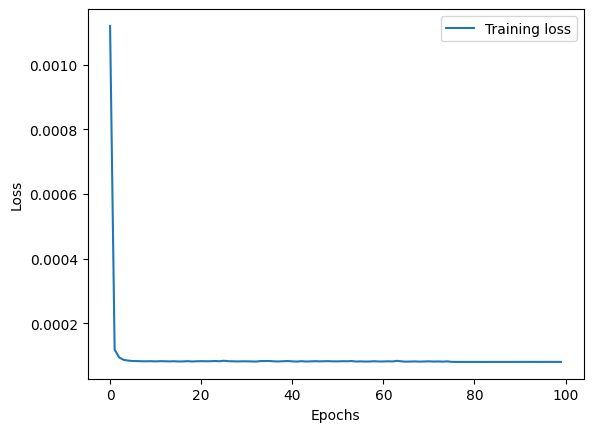

In [8]:
# Train the new deep hedging model


M2_TST = time.time()
# Instantiate an optimizer (i.e. a (Stochastic) Gradient Descent algorithm)
optimizer = torch.optim.Adam(complete_network.parameters(), lr=lr)

# Instantiate a scheduler to decrease the learning rate during training according to a pre-defined rule
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

train_loader = DataLoader(TensorDataset(Train), batch_size=batch_size, shuffle=True)

losses = []
training_loop = tqdm(range(n_epochs)) 
for epoch in training_loop:
    epoch_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()

        batch = batch[0]  
        s_T = batch[:, -1]

        log_S_t = torch.log(batch[:, :-1])
        times = torch.sqrt(T-torch.linspace(0, T, steps=N+1)[:-1]).repeat(batch.shape[0],1)
        inputs = torch.stack((times,log_S_t), dim=2)
    
        
        H = complete_network(inputs).squeeze()

        S = batch[:, 1:] - batch[:, :-1]  

        batch_loss = ((g(s_T) - p - torch.sum(H * S, dim=1)) ** 2).mean() 

        batch_loss.backward()
        optimizer.step()

        epoch_loss += batch_loss.item()

    # Average loss per batch
    epoch_loss /= len(train_loader)
    training_loop.set_postfix(loss=epoch_loss)
    
    # Step the scheduler
    scheduler.step()

    # Save training loss for plotting
    losses.append(epoch_loss)
M2_TET = time.time()
# Plot the training loss
plt.plot(losses, label='Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Question 3.c - Model evaluation

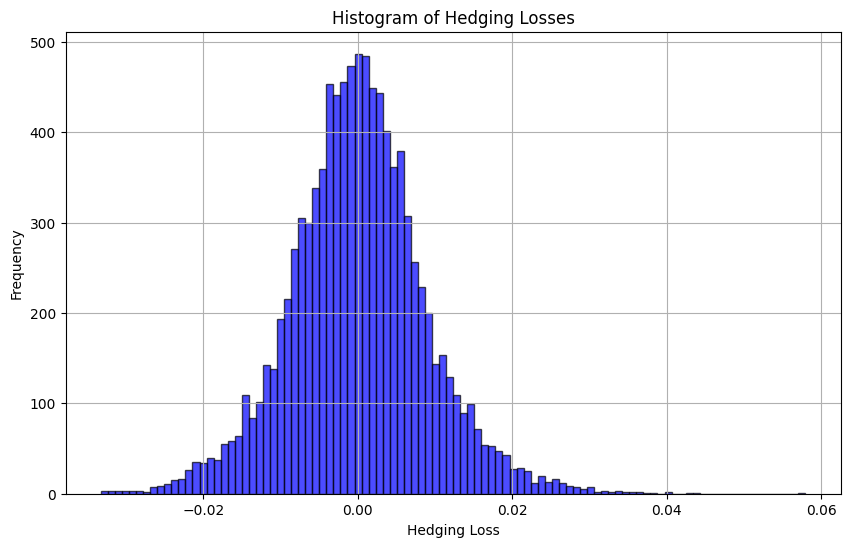

Mean of hedging losses: 0.0001
Standard deviation of hedging losses: 0.0088


In [9]:
import numpy as np
losstest = []
times = torch.linspace(0, T, steps=N+1).unsqueeze(1)
for i in range(10**4):
        # Prepare the inputs for the model
        log_S_t = torch.log(Test[i][:-1]).unsqueeze(1)  # Shape: (num_steps, 1)

        # Combine inputs (log(S_t), t_j) for the model
        inputs = torch.cat((torch.sqrt(T-times[:-1]),log_S_t), dim=1)  # Shape: (num_steps, 2)

        # Predict H_tj using the model
        H = complete_network(inputs)  # Shape: (num_steps, 1)
        # Compute the final loss for this path
        path_loss = g(Test[i][-1]) - p - torch.sum(H.squeeze() * (Test[i][1:] - Test[i][:-1]))
        losstest.append(path_loss.detach())



# Plot a histogram of the hedging losses and print mean and standard deviation

plt.figure(figsize=(10, 6))
plt.hist(losstest, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title('Histogram of Hedging Losses')
plt.xlabel('Hedging Loss')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Print mean and standard deviation of the losses
mean_loss = np.mean(losstest)
std_loss = np.std(losstest)
print(f"Mean of hedging losses: {mean_loss:.4f}")
print(f"Standard deviation of hedging losses: {std_loss:.4f}")

### Question 3.d - Model comparison

Our models have similar performance, however we noticed that the second deep hedging model required significantly less parameters and took less time to train.

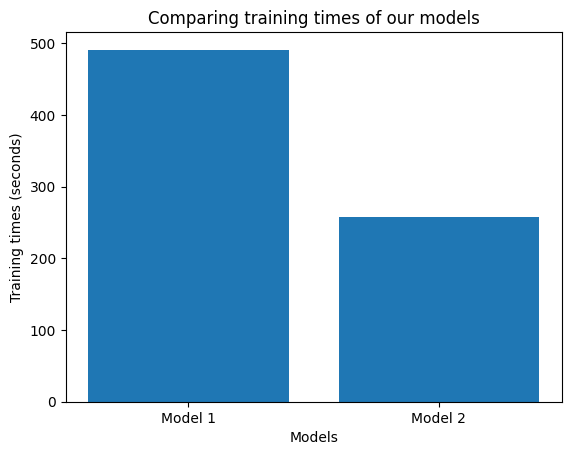

Training time for the first deep heding model:490.75706911087036 seconds.
Training time for the second deep heding model:257.42216324806213 seconds.


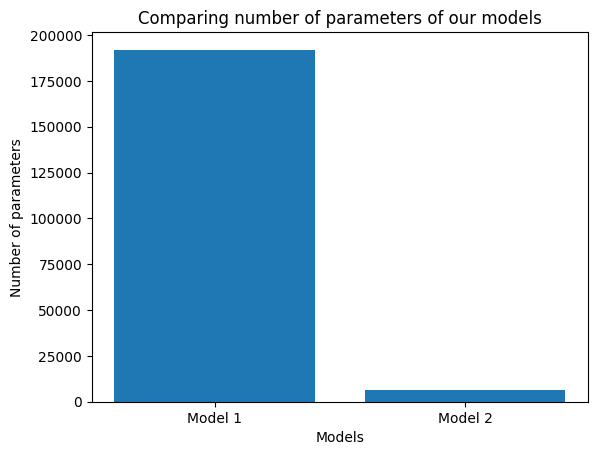

Number of parameters in the first deep hedging model:192030.
Number of parameters in the second deep heding model:6465.


In [10]:
# Compare with the first deep hedging model (Exercise 1)
# Keep the comparison fair: evaluate run-time, performance and number of parameters.
models = ['Model 1', 'Model 2']
times = [M1_TET - M1_TST, M2_TET - M2_TST]
plt.figure()
plt.bar(models, times)
plt.xlabel('Models')
plt.ylabel('Training times (seconds)')
plt.title('Comparing training times of our models')
plt.show()
print(f'Training time for the first deep heding model:{M1_TET - M1_TST} seconds.')
print(f'Training time for the second deep heding model:{M2_TET - M2_TST} seconds.')

parameters = [sum([param.numel()for network in networks for param in network.parameters()]), sum([param.numel() for param in complete_network.parameters()])]
plt.figure()
plt.bar(models, parameters)
plt.xlabel('Models')
plt.ylabel('Number of parameters')
plt.title('Comparing number of parameters of our models')
plt.show()



print(f'Number of parameters in the first deep hedging model:{sum([param.numel()for network in networks for param in network.parameters()])}.')
print(f'Number of parameters in the second deep heding model:{sum([param.numel() for param in complete_network.parameters()])}.')
